<a href="https://colab.research.google.com/github/redish0317/cp1/blob/main/cp1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import requests
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [92]:
def crawl_id():
    url = 'http://www.wanted.jobs/api/v4/jobs?'

    params ={1656232918453:'',    #사용자번호?
    'country': 'all',
    'tag_type_ids': 873,    #직무 카테고리 고유 id
    'job_sort': 'job.latest_order',    #최신순 정렬
    'locations': all,
    'years': -1,    #경력 이상
    'years': -1,    #경력 이하    경력상관없이 검색하려면 -1
    'limit': 100,    #한 번에 조회 가능한 수 (최대100)
    'offset': 100}    #조회할 게시물의 첫 index        ex) limit=100 offset=10  => 10번게시물부터 110번게시물까지 크롤링

    r = requests.get(url,
                     params = params)
    r = r.json()
    df = pd.json_normalize(r['data'])
    return df


def crawl_job(id_list):
    df = pd.DataFrame()
    for id in id_list:
        url = f'https://www.wanted.jobs/api/v4/jobs/{id}?1656259528432'
        r = requests.get(url)
        r = r.json()['job']
        df = pd.concat([df,pd.json_normalize(r)],axis=0)
    return df.reset_index(drop=True)


def engineering(df):
    #사용하지 않을 컬럼 drop
    drop_col = ['is_crossboarder','like_count','is_like','score','company_images','status','is_bookmark','is_company_follow',
            'compare_country','matching_score','short_link','position','address.geo_location.n_location.address','address.geo_location.location.lat','address.geo_location.location.lng','address.geo_location.viewport.northeast.lat',
            'address.geo_location.viewport.northeast.lng','address.geo_location.viewport.southwest.lat','address.geo_location.viewport.southwest.lng','address.geo_location.bounds','detail.intro','detail.benefits','company.id','company.application_response_stats.level',
            'company.application_response_stats.delayed_count','company.application_response_stats.remained_count', 'company.application_response_stats.type', 'company.name', 'logo_img.origin', 'logo_img.thumb', 'title_img.origin', 'title_img.thumb', 'reward.formatted_total', 'reward.formatted_recommender', 'reward.formatted_recommendee', 'address.geo_location.bounds.northeast.lat', 'address.geo_location.bounds.northeast.lng', 'address.geo_location.bounds.southwest.lat', 'address.geo_location.bounds.southwest.lng', 'address.geo_location']
    df = df.drop(drop_col,axis=1).iloc[:,1:]

    #skill_tags 비어있는 행 제거
    df = df.loc[df['skill_tags'].apply(lambda x :  x !='[]')]


    return df.reset_index(drop=True)


In [30]:
df_id = crawl_id()

df_job = crawl_job(df_id['id'])

df = pd.concat([df_id,df_job],axis=1)

#df = engineering(df)

df.head()

,status,is_like,is_bookmark,compare_country,due_time,like_count,id,matching_score,position,score,...,logo_img.thumb,title_img.origin,title_img.thumb,reward.formatted_total,reward.formatted_recommender,reward.formatted_recommendee,address.geo_location.bounds.northeast.lat,address.geo_location.bounds.northeast.lng,address.geo_location.bounds.southwest.lat,address.geo_location.bounds.southwest.lng
0,active,False,False,True,None,19,66372,None,Java Spring Engineer,None,...,https://static.wanted.co.kr/images/wdes/0_5.21...,https://static.wanted.co.kr/images/company/178...,https://static.wanted.co.kr/images/company/178...,"￦1,000,000","￦500,000","￦500,000",NaN,NaN,NaN,NaN
1,active,False,False,True,None,13,67155,None,Laravel Engineer,None,...,https://static.wanted.co.kr/images/wdes/0_5.21...,https://static.wanted.co.kr/images/company/178...,https://static.wanted.co.kr/images/company/178...,"￦1,000,000","￦500,000","￦500,000",NaN,NaN,NaN,NaN
2,active,False,False,True,None,42,66379,None,Node.js Engineer,None,...,https://static.wanted.co.kr/images/wdes/0_5.21...,https://static.wanted.co.kr/images/company/178...,https://static.wanted.co.kr/images/company/178...,"￦1,000,000","￦500,000","￦500,000",NaN,NaN,NaN,NaN
3,active,False,False,True,2022-07-07,0,115798,None,파우더룸 백엔드 서비스 개발,None,...,https://static.wanted.co.kr/images/wdes/0_5.5d...,https://static.wanted.co.kr/images/company/155...,https://static.wanted.co.kr/images/company/155...,"￦1,000,000","￦500,000","￦500,000",NaN,NaN,NaN,NaN
4,active,False,False,True,2022-07-07,0,115796,None,파우더룸 프론트엔드 서비스 개발,None,...,https://static.wanted.co.kr/images/wdes/0_5.5d...,https://static.wanted.co.kr/images/company/155...,https://static.wanted.co.kr/images/company/155...,"￦1,000,000","￦500,000","￦500,000",NaN,NaN,NaN,NaN


In [ ]:
df.to_excel('wanted.xlsx')

#폐기

In [ ]:
def make_soup(url):
    response = requests.get(url)
    html = response.text
    soup = BeautifulSoup(html, 'html.parser')
    return soup
url = 'https://www.wanted.jobs/wd/109904'

soup = str(make_soup(url))

url_list = ['https://www.wanted.jobs/wd/'+ str(i) for i in df['id']]

#서론
Introduction = soup[soup.find('"jd":"') + 6 : soup.find('\\n\\n\\n주요업무\\n')]

#주요업무, 책임
responsibilities = soup[soup.find('\\n\\n\\n주요업무\\n') + 12 : soup.find('\\n\\n자격요건\\n')]

#요구자격
basic_qualifications = soup[soup.find('\\n\\n자격요건\\n') + 12 : soup.find('\\n\\n우대사항\\n')]

#우대자격
preferred_qualifications = soup[soup.find('\\n\\n우대사항\\n') + 10 : soup.find('\\n\\n혜택 및 복지\\n###')]

#복지
company_benefits = soup[soup.find('\\n\\n혜택 및 복지\\n###') + 16 : soup.find('","company_name":"')]

pd.DataFrame({'Introduction':Introduction,
              'responsibilities':responsibilities,
              'basic_qualifications':basic_qualifications,
              'preferred_qualifications':preferred_qualifications,
              'company_benefits':company_benefits},index=[0])

,Introduction,responsibilities,basic_qualifications,preferred_qualifications,company_benefits
0,"빌리오(BIllyo)\n#크리에이터의 고민 해결!\n콘텐츠 제작 커뮤니티, ‘빌리오...",[주요 업무]\n- 빌리오(Billyo) 모바일 서비스를 위한 API 개발 및 유지...,Python 기반 Restful API 설계 및 구현 경험이 3년 이상 있으시거나 ...,- O2O 플랫폼 비즈니스에 대한 흥미와 관심이 있는 분\n- 크리에이터 시장에 관...,"이런 게 좋아요!\n빌리오 팀원들은 함께하는 동료를 소중히 여기며, 함께 성장하면..."


#EDA

In [10]:
import matplotlib.pyplot as plt

In [1]:
from google.colab import drive
drive.mount('concent')

Mounted at concent


In [95]:
df = pd.read_csv('/content/concent/MyDrive/data/wanted.csv')
df = engineering(df)

In [97]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1751 entries, 0 to 1750
Data columns (total 18 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   id                                           1751 non-null   int64  
 1   due_time                                     481 non-null    object 
 2   skill_tags                                   1751 non-null   object 
 3   company_tags                                 1751 non-null   object 
 4   category_tags                                1751 non-null   object 
 5   address.country                              1751 non-null   object 
 6   address.full_location                        1746 non-null   object 
 7   address.geo_location.n_location.lat          1536 non-null   float64
 8   address.geo_location.n_location.lng          1536 non-null   float64
 9   address.geo_location.location_type           1735 non-null   object 
 10  

In [37]:
df['company.application_response_stats.avg_rate'].describe()

count    2077.000000
mean       79.046509
std        23.624639
min         0.000000
25%        73.600000
50%        87.500000
75%        94.100000
max       100.000000
Name: company.application_response_stats.avg_rate, dtype: float64

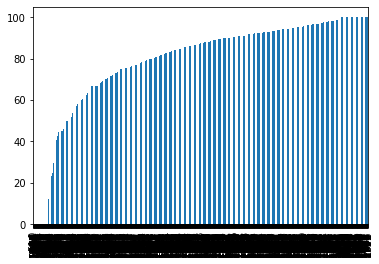

In [38]:
df['company.application_response_stats.avg_rate'].sort_values().plot.bar()

In [42]:
df['address.country'].value_counts(normalize=True)

Korea        0.980260
Japan        0.010592
Taiwan       0.007703
Singapore    0.000963
Other        0.000481
Name: address.country, dtype: float64

In [36]:
df['company.application_response_stats.avg_rate'].isnull().sum()

0

In [71]:
df['skill_tags']

0       [{'title': 'MongoDB', 'id': 1462, 'kind_title'...
1       [{'title': 'Android', 'id': 1438, 'kind_title'...
2       [{'title': 'Android', 'id': 1438, 'kind_title'...
3       [{'title': 'iOS', 'id': 1457, 'kind_title': 'S...
4       [{'title': 'Git', 'id': 1411, 'kind_title': 'S...
                              ...                        
2072                                                   []
2073                                                   []
2074                                                   []
2075                                                   []
2076                                                   []
Name: skill_tags, Length: 2077, dtype: object

In [87]:
df['skill_tags'].apply(lambda x :  x !='[]')

0        True
1        True
2        True
3        True
4        True
        ...  
2072    False
2073    False
2074    False
2075    False
2076    False
Name: skill_tags, Length: 2077, dtype: bool